# A real-world case (Biomimetics: space technology)
Here we use a some data produced by precisely modelling a nanostructured solar array inspired by the moth eye. We analyze the relations (found by **dcgpy** **symbolic_regression** using **mes**) between the cell efficiency and 12 different model parameters (thickness, etc..). 

* The data were generated in the context of the European Space Agency Ariadna study on bio-inspired solar cells (http://www.esa.int/gsp/ACT/projects/diatom/).

* The fits were generated evolving 126 populations (size 8) via **dcgpy.mes(10000, max_mut=15)** on an AMD EPYC 7702 64-Core Processor (~20 minutes to complete)

Data points are pickled into a file named *moth_data.pk* in the form of a tuple of two arrays Xs, Ys.

The fitted expressions are pickled into a file named *result.pk* in a list: result[prob_id][0] = fitnesses result[prob_id][1] = chromosomes

This tutorial is informative as it shows the wide diversity and quality of models produced by unconnected evolutions and their difference with respect to the fit error.

## Preliminaries

In [1]:
# Core imports
import dcgpy # This was compiled in bertha from github HEAD (v1.5 is unreleased)
import pygmo as pg
import numpy as np
# Sympy is nice to have for basic symbolic manipulation.
from sympy import init_printing
from sympy.parsing.sympy_parser import *
init_printing()
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
# Pickling
import pickle as pk

In [2]:
# Load the data to fit
with open("moth_data.pk", "rb") as f:
    Xs,Ys  = pk.load(f)
# Load the best solutions found running dcgpy.mes(10000, max_mut=15) on 126 separate runs
#with open("eph_3_r_1_c_16_lb_17_sum_diff_mul_diff_exp.pk", "rb") as f:
with open("eph_4_r_1_c_16_lb_15_sum_diff_mul_div_exp_gaussian.pk", "rb") as f:
    results = pk.load(f)
kernel_list = ["sum", "diff", "mul", "div", "exp", "gaussian"]

In [3]:
# We define the kernel set that was used to produce the runs
ss = dcgpy.kernel_set_double(kernel_list)

In [4]:
# Since we have not pickled all the objects used during the experiment, we need to reconstruct the 
# udp and the data in a good format.
def reconstruct_udp(prob_id):
    X = np.reshape(Xs[prob_id], (len(Xs[prob_id]),1))
    Y = np.reshape(Ys[prob_id], (len(Ys[prob_id]),1))
    udp = dcgpy.symbolic_regression(points = X, labels = Y, kernels=ss(), n_eph=4, rows =1, cols=16, levels_back=17, multi_objective=False)
    return (udp, X, Y)

In [5]:
# We also want to know (at a glance) if the experimental setup worked well in terms of MSEs
mses = [min(a[0]) for a in results]
print("Best  fit: prob-id ", np.argmin(mses), "| Value: ", mses[np.argmin(mses)][0])
print("Worst fit: prob-id ", np.argmax(mses), "| Value: ", mses[np.argmax(mses)][0])
print("On average: ", sum(mses)/len(mses))

Best  fit: prob-id  4 | Value:  3.359546731194255e-06
Worst fit: prob-id  0 | Value:  2.3801558148325692e-05
On average:  [1.0948612e-05]


## The best fits found

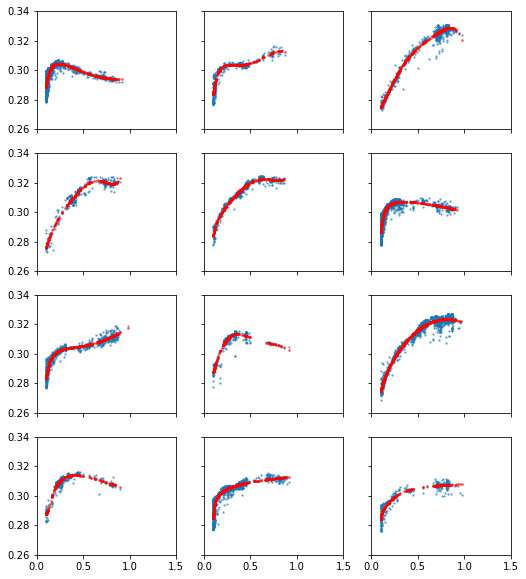

In [6]:
# The data and best fits at a glance
fig, axes = plt.subplots(nrows = 4, ncols=3, sharex=True, sharey=True, figsize=(8.5,10))
for i, ax in enumerate(np.reshape(axes,(12))[:12]):
    udp, X, Y = reconstruct_udp(i)
    ax.scatter(X, Y, s=2.0, alpha=0.5)
    best_run = np.argmin(results[i][0])
    best_dv = results[i][1][best_run]
    Y_pred = udp.predict(X, best_dv)
    ax.scatter(X, Y_pred, s=3.0, alpha=0.5, c = 'r')

ax.set_xlim(0, 1.5)
ax.set_ylim(0.26, 0.34)

In [7]:
# Lets peek into the best fits functional forms. Each of the 12 problems is here
## assigned an id
from IPython.display import display, Math
for prob_id in range(12):
    udp, X, Y = reconstruct_udp(prob_id)
    best_run= np.argmin(results[prob_id][0])
    best_x = results[prob_id][1][best_run]
    best_f = results[prob_id][0][best_run]
    s = parse_expr(udp.prettier(best_x))[0].simplify()
    display("prob_id: {}, err: {}".format(prob_id, best_f[0]), Math(r'{}'.format(s._repr_latex_())))
    
# NOTE: selecting the fit with the best MSE may not be ideal as best formulas do get unnecessarily complex

'prob_id: 0, err: 2.3801558148325692e-05'

<IPython.core.display.Math object>

'prob_id: 1, err: 1.5481952594443556e-05'

<IPython.core.display.Math object>

'prob_id: 2, err: 4.866500757662433e-06'

<IPython.core.display.Math object>

'prob_id: 3, err: 7.993101895616535e-06'

<IPython.core.display.Math object>

'prob_id: 4, err: 3.359546731194255e-06'

<IPython.core.display.Math object>

'prob_id: 5, err: 1.686027444316002e-05'

<IPython.core.display.Math object>

'prob_id: 6, err: 9.922429392571683e-06'

<IPython.core.display.Math object>

'prob_id: 7, err: 8.515167695863056e-06'

<IPython.core.display.Math object>

'prob_id: 8, err: 5.7033656245193685e-06'

<IPython.core.display.Math object>

'prob_id: 9, err: 4.523905989067585e-06'

<IPython.core.display.Math object>

'prob_id: 10, err: 1.9017543270061446e-05'

<IPython.core.display.Math object>

'prob_id: 11, err: 1.1337997121125522e-05'

<IPython.core.display.Math object>

## Looking for elegant forms
Some of the best fits found seem to be unnecessarily complex, we here look in the results for more elegant forms with a marginally worse MSA

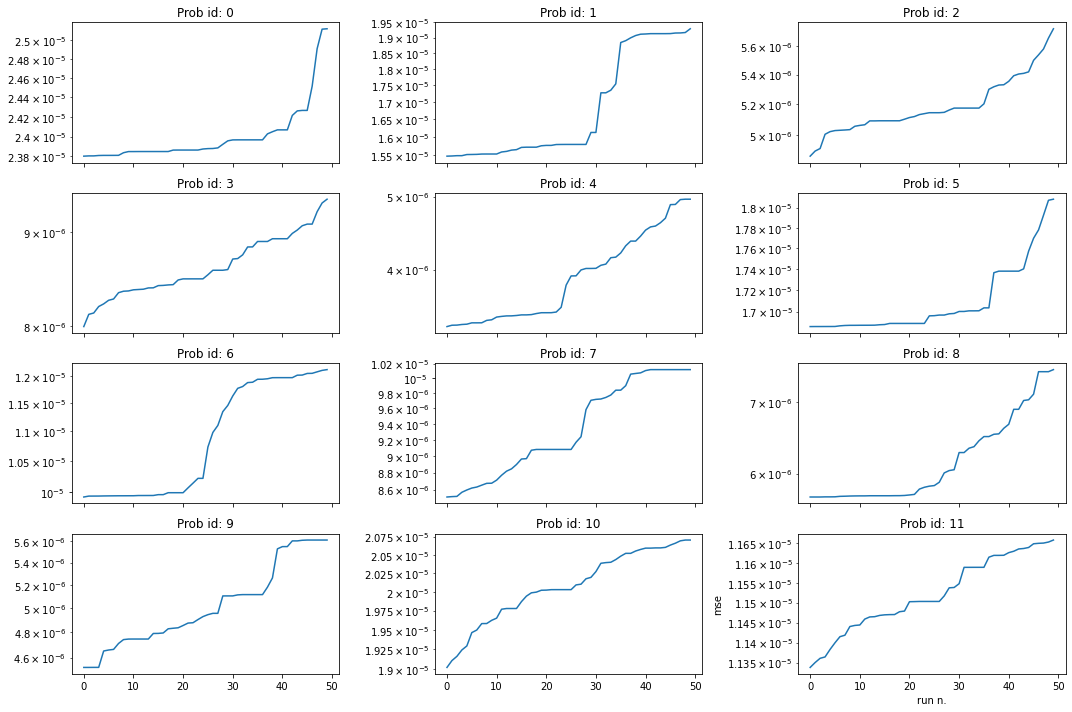

In [8]:
# Lets take for each problem the best 50 fits found and plot the corresponding final MSE
fig, axes = plt.subplots(nrows = 4, ncols=3, sharex=True, figsize=(15,10))
for i, ax in enumerate(np.reshape(axes,(12))[:12]):
    a = results[i]
    ax.semilogy(sorted(a[0])[:50])
    ax.title.set_text("Prob id: " + str(i))
plt.xlabel("run n.")
plt.ylabel("mse")
plt.tight_layout()
# Conclusion: there are many formulas with similar error that can be considered as equally good fits

## Showing the best 5 fits

In [9]:
for prob_id in range(12):
    print("---------------------------------------------------------")
    print("Best five fits for id: ", prob_id)
    a = results[prob_id]
    fits = a[0]
    best_idxs = sorted(range(126), key = lambda x: fits[x])
    for best_isl in best_idxs[:5]:
        best_x = a[1][best_isl]
        best_f = a[0][best_isl]
        udp, X, Y = reconstruct_udp(prob_id)
        s = parse_expr(udp.prettier(best_x))[0].simplify()
        display("prob_id: {}, err: {}".format(prob_id, best_f[0]), Math(r'{}'.format(s._repr_latex_())))
    print("---------------------------------------------------------")


---------------------------------------------------------
Best five fits for id:  0


'prob_id: 0, err: 2.3801558148325692e-05'

<IPython.core.display.Math object>

'prob_id: 0, err: 2.380412125841117e-05'

<IPython.core.display.Math object>

'prob_id: 0, err: 2.3804219347209996e-05'

<IPython.core.display.Math object>

'prob_id: 0, err: 2.3808190703491017e-05'

<IPython.core.display.Math object>

'prob_id: 0, err: 2.3809219218852146e-05'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  1


'prob_id: 1, err: 1.5481952594443556e-05'

<IPython.core.display.Math object>

'prob_id: 1, err: 1.5486489454637892e-05'

<IPython.core.display.Math object>

'prob_id: 1, err: 1.5494780218604477e-05'

<IPython.core.display.Math object>

'prob_id: 1, err: 1.549478021860451e-05'

<IPython.core.display.Math object>

'prob_id: 1, err: 1.5524996126148153e-05'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  2


'prob_id: 2, err: 4.866500757662433e-06'

<IPython.core.display.Math object>

'prob_id: 2, err: 4.8981961254319396e-06'

<IPython.core.display.Math object>

'prob_id: 2, err: 4.9140689166325595e-06'

<IPython.core.display.Math object>

'prob_id: 2, err: 5.004121929538379e-06'

<IPython.core.display.Math object>

'prob_id: 2, err: 5.0208570048206605e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  3


'prob_id: 3, err: 7.993101895616535e-06'

<IPython.core.display.Math object>

'prob_id: 3, err: 8.116838729621195e-06'

<IPython.core.display.Math object>

'prob_id: 3, err: 8.13057337419324e-06'

<IPython.core.display.Math object>

'prob_id: 3, err: 8.19691765672383e-06'

<IPython.core.display.Math object>

'prob_id: 3, err: 8.224153596665173e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  4


'prob_id: 4, err: 3.359546731194255e-06'

<IPython.core.display.Math object>

'prob_id: 4, err: 3.3734252967348888e-06'

<IPython.core.display.Math object>

'prob_id: 4, err: 3.3746957690291797e-06'

<IPython.core.display.Math object>

'prob_id: 4, err: 3.3811044286786395e-06'

<IPython.core.display.Math object>

'prob_id: 4, err: 3.3842683416733736e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  5


'prob_id: 5, err: 1.686027444316002e-05'

<IPython.core.display.Math object>

'prob_id: 5, err: 1.686067254813111e-05'

<IPython.core.display.Math object>

'prob_id: 5, err: 1.686069307097475e-05'

<IPython.core.display.Math object>

'prob_id: 5, err: 1.6860856181522074e-05'

<IPython.core.display.Math object>

'prob_id: 5, err: 1.686098183474468e-05'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  6


'prob_id: 6, err: 9.922429392571683e-06'

<IPython.core.display.Math object>

'prob_id: 6, err: 9.936575700754542e-06'

<IPython.core.display.Math object>

'prob_id: 6, err: 9.936942645025763e-06'

<IPython.core.display.Math object>

'prob_id: 6, err: 9.937353947520078e-06'

<IPython.core.display.Math object>

'prob_id: 6, err: 9.938981126078224e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  7


'prob_id: 7, err: 8.515167695863056e-06'

<IPython.core.display.Math object>

'prob_id: 7, err: 8.519576231706857e-06'

<IPython.core.display.Math object>

'prob_id: 7, err: 8.522266408037304e-06'

<IPython.core.display.Math object>

'prob_id: 7, err: 8.569811491073491e-06'

<IPython.core.display.Math object>

'prob_id: 7, err: 8.596454393800356e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  8


'prob_id: 8, err: 5.7033656245193685e-06'

<IPython.core.display.Math object>

'prob_id: 8, err: 5.703378409998452e-06'

<IPython.core.display.Math object>

'prob_id: 8, err: 5.7033784099984615e-06'

<IPython.core.display.Math object>

'prob_id: 8, err: 5.705047245789752e-06'

<IPython.core.display.Math object>

'prob_id: 8, err: 5.705078353147797e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  9


'prob_id: 9, err: 4.523905989067585e-06'

<IPython.core.display.Math object>

'prob_id: 9, err: 4.523956586681867e-06'

<IPython.core.display.Math object>

'prob_id: 9, err: 4.524279590137839e-06'

<IPython.core.display.Math object>

'prob_id: 9, err: 4.524279590138164e-06'

<IPython.core.display.Math object>

'prob_id: 9, err: 4.651129097622205e-06'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  10


'prob_id: 10, err: 1.9017543270061446e-05'

<IPython.core.display.Math object>

'prob_id: 10, err: 1.9104544589813626e-05'

<IPython.core.display.Math object>

'prob_id: 10, err: 1.9158737383062652e-05'

<IPython.core.display.Math object>

'prob_id: 10, err: 1.9240171327253178e-05'

<IPython.core.display.Math object>

'prob_id: 10, err: 1.9291883990542647e-05'

<IPython.core.display.Math object>

---------------------------------------------------------
---------------------------------------------------------
Best five fits for id:  11


'prob_id: 11, err: 1.1337997121125522e-05'

<IPython.core.display.Math object>

'prob_id: 11, err: 1.135016956476325e-05'

<IPython.core.display.Math object>

'prob_id: 11, err: 1.1360665073366816e-05'

<IPython.core.display.Math object>

'prob_id: 11, err: 1.1364062900679142e-05'

<IPython.core.display.Math object>

'prob_id: 11, err: 1.138267448015574e-05'

<IPython.core.display.Math object>

---------------------------------------------------------
